# Applied-Quantum-Machine-Learning

## Final Report 
### Quantum Annealing for Non-negative/binary matrix factorization

Author: Jose Pablo Quesada-Molina (Ph.D. Candidate at DICA, Politecnico di Milano )

# Problem description and its QUBO formulation

This work aims to partially reproduce the results of the **Non-negative/Binary Matrix Factorization NBMF** method reported in:

1. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0206653
2. https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0244026


The matrix factorization method considered in this work, described as Non-negative/Binary Matrix Factorization (NBMF), aims to find a decomposition for an $n\times m$ matrix, $A$, into the product of two matrices, $B$ and $C$, where $B$ is an $n\times k$ matrix, $C$ is a $k\times m$ matrix and $k << $ min$(n,m)$. That is, find $B$ and $C$ such that: 

\begin{equation}
  A \approx BC 
\end{equation}

Specific constraints are enforced on $B$ and $C$: the components of $B$ must be non-negative (i.e., $B_{ij} \geq 0$) and the components of $C$ must be binary (i.e., $C_{ij} \in \{0, 1\}$).


There are two main subroutines employed to perform the NBMF. The first one, is related to the solution of a non-negative least squares problem (bound-constrained minimization) associated to the determination of $B$. For this,  Nelder-Mead method has been chosen. A regularization part, $\alpha \| X\|_{F}$, with $\alpha = 1\times 10^{-2}$, is added to the objective function to avoid over-fitting. By selecting the Frobenius Norm, $\|D\|_{F}:= \sqrt{Tr(DD^{T})}=\sqrt{\sum_{i}\sum_{j}|d_{ij}|^{2}}$, the objective function can be easily transformed to a matrix trace version:

\begin{equation}
  {B= arg min}_{X \in {\mathbb{R}}^{+n\times k}} Tr((A-XC)(A-XC)^{T})+\alpha Tr(XX^{T})
\end{equation}

or to a scalar one:

\begin{equation}
  {B= arg min}_{X \in {\mathbb{R}}^{+n\times k}} \sum_{i=0}^{n}\sum_{j=0}^{m}(A_{i,j}-\sum_{l=0}^{k}X_{i,l}C_{l,j})^{2}+\alpha\sum_{l=0}^{k} (X_{i,l})^{2}
\end{equation}

For the second subroutine, we focus on utilizing a D-Wave 2000Q quantum annealer to compute:

\begin{equation}
    {C= arg min}_{X \in \{0,1\}^{k\times m}} \| A-BX\|_{F}^{2}
\end{equation}

The previous equation can be solved by solving a set of independent optimization problems; one for each column of $C$. That is, if we denote the $j^{th}$ columns of $C$ and $A$ by $C_{j}$ and $A_{j}$, respectively, then the previous equation can be re-written as:

\begin{equation}
    {C_{j}=arg min}_{q\in \{0,1\}^{k}} \|A_{j}-Bq\|_{L_{2}}^{2}   
\end{equation}

where $q$ represents a vector of $k$ binary variables and the solution for $C_{j}$. In this way, it is possible to move from an equation which involves the optimization of $km$ binary variables, to one involving only $k$ binary variables. 

The binary least squares problem associated to $C_{j}$ can be readily represented in the form of a QUBO, by setting:

\begin{align}
    Q_{k,k}=\sum_{i=1}^{n} B_{ik}(B_{ik}-2A_{ij})\\
    Q_{k,l}=2\sum_{l=1}^{k-1}\sum_{i=1}^{n} B_{ik}B_{il}
\end{align}


# Import libraries and modules 

In [25]:
import cv2
import os
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import scipy as sp
from scipy.optimize import minimize
from matplotlib import transforms
from scipy import ndimage
import time
from numpy import asarray
from numpy import savetxt
import pickle
import h5py 
from dwave.system.composites import FixedEmbeddingComposite, EmbeddingComposite
from dwave.system.samplers import DWaveSampler
from dimod.binary_quadratic_model import BinaryQuadraticModel
import matplotlib.pyplot as plt
import time
from collections import defaultdict
from itertools import combinations
import math
import networkx as nx #allow to draw topologies
import dwave_networkx as dnx #allow to draw topologies
import minorminer
import dimod
import neal
from neal import SimulatedAnnealingSampler
from dwave.system import DWaveCliqueSampler,ReverseAdvanceComposite
path=os.getcwd()

# Select QPU device topology and check QPU Properties

In [26]:
device = DWaveSampler(solver={'topology__type': 'chimera'})
print(device)

In [4]:
device_name = device.solver.data['id']
qubit_count = device.solver.data['properties']['num_qubits']
number_couplers = len(device.solver.data['properties']['couplers'])
shots_range = device.solver.data['properties']['num_reads_range']
print("Running on '{}' with '{}' physical qubits, '{}' couplers and shots in the range '{}'.".format(device_name,
                                                                                             qubit_count,
                                                                                             number_couplers,
                                                                                             shots_range))

Running on 'DW_2000Q_6' with '2048' physical qubits, '5974' couplers and shots in the range '[1, 10000]'.


In [8]:
for key, value in device.solver.data['properties'].items():
    
    if isinstance(value, list) and len(value)>5:
        value = str(value [:5]) + "... {} in total".format(len(value))
    
    if key == "parameters":
        continue
        
    print("{}: {}".format(key, value))

num_qubits: 2048
qubits: [0, 1, 2, 3, 4]... 2041 in total
couplers: [[0, 4], [1, 4], [2, 4], [3, 4], [0, 5]]... 5974 in total
h_range: [-2.0, 2.0]
j_range: [-1.0, 1.0]
supported_problem_types: ['ising', 'qubo']
vfyc: False
anneal_offset_ranges: [[-0.13600744081137645, 0.009789701817991983], [-0.13875149009394658, 0.009566264844367785], [-0.1369361147194918, 0.016674382560332858], [-0.13712184366968314, 0.010881002839541706], [-0.1377032158503334, 0.00946709608971043]]... 2048 in total
anneal_offset_step: 0.003078008946238068
anneal_offset_step_phi0: 0.00027992071513567937
annealing_time_range: [1.0, 2000.0]
chip_id: DW_2000Q_6
default_annealing_time: 20.0
default_programming_thermalization: 1000.0
default_readout_thermalization: 0.0
extended_j_range: [-2.0, 1.0]
h_gain_schedule_range: [-5.0, 5.0]
max_anneal_schedule_points: 12
max_h_gain_schedule_points: 20
num_reads_range: [1, 10000]
per_qubit_coupling_range: [-9.0, 6.0]
problem_run_duration_range: [0.0, 1000000.0]
programming_thermal

In [13]:
C16 = dnx.chimera_graph(16)# Ideal graph for Chimera lattice 16,16,4
qpu_sampler = DWaveSampler(solver={'topology__type': 'chimera'})
QPUGraph = nx.Graph(qpu_sampler.edgelist) # Working graph of the QPU


corresponding_nodes = sum(node in C16.nodes for node in QPUGraph.nodes)
corresponding_edges = sum(edge in C16.edges for edge in QPUGraph.edges) 

print("Total Chimera nodes are {}, corresponding in QPU are {}, missing ones are {}".format(len(C16.nodes), corresponding_nodes, len(C16.nodes)-corresponding_nodes))
print("Total Chimera edges are {}, corresponding in QPU are {}, missing ones are {}".format(len(C16.edges), corresponding_edges, len(C16.edges)-corresponding_edges))

Total Chimera nodes are 2048, corresponding in QPU are 2041, missing ones are 7
Total Chimera edges are 6016, corresponding in QPU are 5974, missing ones are 42


# Minorminer use to determine the maximum instance size that can fit on the QPU

To solve the problem, the corresponding graph must be minor embedded into a QPU’s graph. The D-Wave’s hardware is composed of bits that are coupled via a “Chimera” graph, *C<sub>M,N,L</sub>*, which consists of an *M-by-N* grid of *K<sub>L,L</sub>* bipartite graphs.  

In https://link.springer.com/content/pdf/10.1007/s11128-015-1150-6.pdf it has been shown that a complete
graph with *LM* nodes can be embedded in *C<sub>M,M,L</sub>*.

Using minorminer ***minorminer.find_embedding()*** it has been found that for **DW_2000Q_6** with a topology *C<sub>16,16,4</sub>*, the maximum number of binary variables that could be used for these problems is 65.


# Generation and visualization of random embeddings for intermediate and maximum instance sizes

<IPython.core.display.Javascript object>


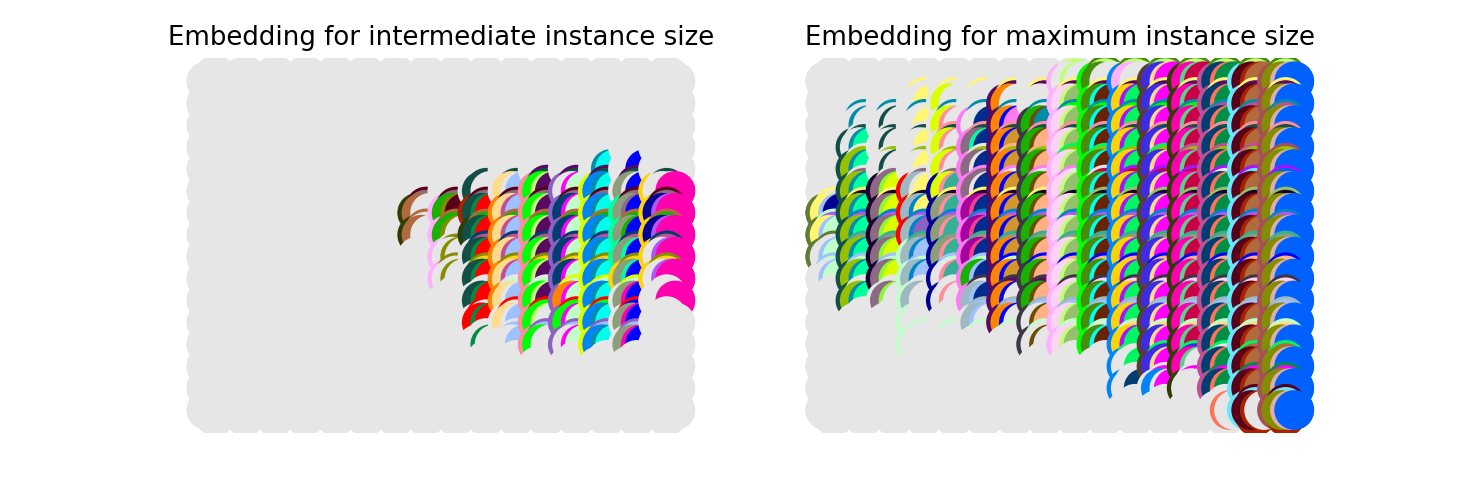

Text(0.5, 1.0, 'Embedding for maximum instance size')

In [60]:
%matplotlib notebook

# Complete graph instances
intermediate_instance_size=35 
max_instance_size=65

# Create figure
fig = plt.figure(figsize=(6,2))

# Setting values to rows and column variables
rows = 1
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

G_NBMF=nx.complete_graph(intermediate_instance_size)
# Try to find an embedding on Chimera using minorminer
embedded_graph = minorminer.find_embedding(G_NBMF.edges(), QPUGraph.edges())

# Plot this mebedding
dnx.draw_chimera_embedding(C16,embedded_graph, with_labels=False)
plt.title('Embedding for intermediate instance size') 


# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

G_NBMF=nx.complete_graph(max_instance_size)

# Try to find an embedding on Chimera using minorminer
embedded_graph = minorminer.find_embedding(G_NBMF.edges(), QPUGraph.edges())

# Plot this embedding
dnx.draw_chimera_embedding(C16,embedded_graph, with_labels=False)
plt.title('Embedding for maximum instance size') 

# Trying to generate the embedding of a complete graph on 66 nodes fails!

In [10]:
#Complete graph of larger size 
G_NBMF=nx.complete_graph(66)

minorminer.find_embedding(G_NBMF.edges(), QPUGraph.edges())

{}

# Visualize intermediate and maximum size instances


<IPython.core.display.Javascript object>


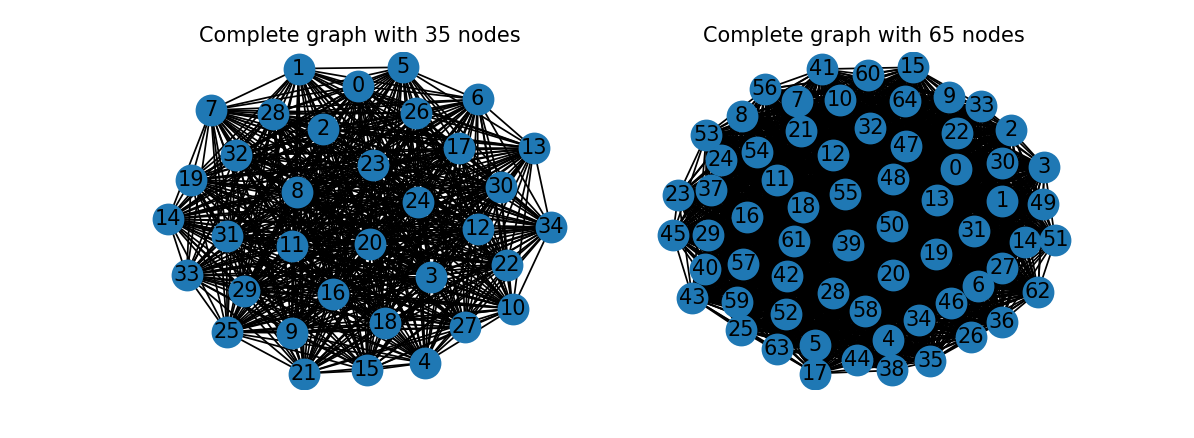

In [14]:
%matplotlib notebook

intermediate_instance_size=35
max_instance_size=65

# create figure
fig = plt.figure(figsize=(6,2))

# setting values to rows and column variables
rows = 1
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

G_NBMF= nx.complete_graph(intermediate_instance_size)
plt.axis('off') 
plt.title('Complete graph with {} nodes'.format(intermediate_instance_size)) 
nx.draw_networkx(G_NBMF, with_labels=True)

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 2)

G_NBMF= nx.complete_graph(max_instance_size)
plt.axis('off') 
plt.title('Complete graph with {} nodes'.format(max_instance_size)) 
nx.draw_networkx(G_NBMF, with_labels=True)

# Generation of embeddings
## Already run for complete graph on  n=35,50 and 65 nodes

In [160]:
# Select the instance size (complete graph on n nodes)
instance_size=50

G_problem = nx.complete_graph(instance_size)#A complete graph on n nodes means that all pairs of distinct nodes have an edge connecting them.
G_QPU = QPUGraph

import time

embedded_graph_list = [] # a list of dictionaries, each dictionary is one embedding . keys> 0 to 34, values> [list of qubits representing one chain]
embedding_time_list = [] 
embedding_number = 100

for i in range(embedding_number):
    start_time = time.time()
    embedded_graph = minorminer.find_embedding(G_problem.edges(), G_QPU.edges())
    elapsed_time = time.time()- start_time
    
    embedded_graph_list.append(embedded_graph)
    embedding_time_list.append(elapsed_time)
    
    print("Computed Embedding {}/{}, elapsed time {:.2f} s".format(i+1, embedding_number, elapsed_time))
    
# save embeddings in .pkl file
file = open("embedded_graph_list{}.pkl".format(instance_size), "wb")
pickle.dump(embedded_graph_list, file)
file.close()

# save embeddings times in .csv file
np.savetxt('embedding_time_list{}.csv'.format(instance_size), embedding_time_list, delimiter=',')

Computed Embedding 1/100, elapsed time 6.01 s
Computed Embedding 2/100, elapsed time 4.95 s
Computed Embedding 3/100, elapsed time 4.58 s
Computed Embedding 4/100, elapsed time 5.95 s
Computed Embedding 5/100, elapsed time 4.32 s
Computed Embedding 6/100, elapsed time 6.70 s
Computed Embedding 7/100, elapsed time 6.84 s
Computed Embedding 8/100, elapsed time 12.46 s
Computed Embedding 9/100, elapsed time 12.35 s
Computed Embedding 10/100, elapsed time 4.90 s
Computed Embedding 11/100, elapsed time 4.41 s
Computed Embedding 12/100, elapsed time 7.02 s
Computed Embedding 13/100, elapsed time 20.86 s
Computed Embedding 14/100, elapsed time 8.19 s
Computed Embedding 15/100, elapsed time 11.86 s
Computed Embedding 16/100, elapsed time 7.38 s
Computed Embedding 17/100, elapsed time 7.55 s
Computed Embedding 18/100, elapsed time 23.43 s
Computed Embedding 19/100, elapsed time 4.99 s
Computed Embedding 20/100, elapsed time 15.59 s
Computed Embedding 21/100, elapsed time 9.43 s
Computed Embeddi

# Variations of the number of qubits, embedding times and chain length statistics with the instance size

The maximum number of qubits of instance size 35 is 454, for instance found in embedding 19
The minimum number of qubits of instance size 35 is 379, for instance found in embedding 20


<IPython.core.display.Javascript object>


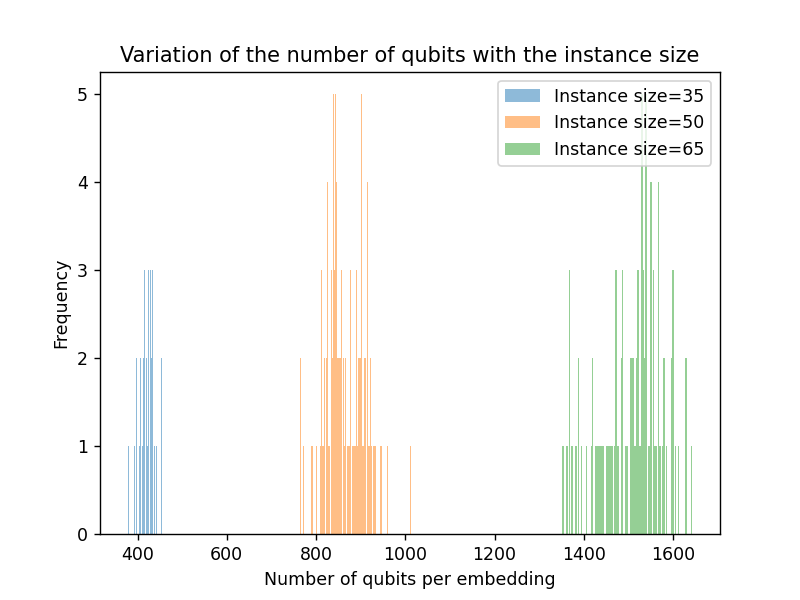

The maximum number of qubits of instance size 50 is 1012, for instance found in embedding 38
The minimum number of qubits of instance size 50 is 763, for instance found in embedding 67
The maximum number of qubits of instance size 65 is 1642, for instance found in embedding 8
The minimum number of qubits of instance size 65 is 1352, for instance found in embedding 99


In [15]:
# Variation of the number of qubits with the instance size

%matplotlib notebook
import itertools

embedding_number = 100
instance_sizes=[35,50,65]


for j in instance_sizes:
    
    instance_size=j


    with open('embedded_graph_list{}.pkl'.format(instance_size), 'rb') as f:
        embedded_graph_list = pickle.load(f)

    embedding_time_list= np.loadtxt('embedding_time_list{}.csv'.format(instance_size), delimiter=',')
    

    qubit_count = []
    max_qubit=0
    i_max=0
    min_qubit=np.inf
    i_min=0
    

    for i in range(embedding_number):

        # creates a list of the values(lists) of the dictionary, extracted from embedded_graph_list[i]
        sublist = [values for keys, values in embedded_graph_list[i].items()]  # a nested list (list of lists) for embedding i,each list has the qubits forming each chain 
        flat_list = set(itertools.chain(*sublist))#flatten the nested list  to count the total number of qubits of embedding i  
        qubit_count.append(len(flat_list))
        if len(flat_list)>max_qubit:
            max_qubit=len(flat_list)
            i_max=i

        if len(flat_list)<min_qubit:
            min_qubit=len(flat_list)
            i_min=i

    print('The maximum number of qubits of instance size {} is {}, for instance found in embedding {}'.format(j,max_qubit,i_max))
    print('The minimum number of qubits of instance size {} is {}, for instance found in embedding {}'.format(j,min_qubit,i_min))
    plt.hist(qubit_count, bins = embedding_number, label='Instance size={}'.format(instance_size), alpha=0.5)
    
plt.legend()
plt.title('Variation of the number of qubits with the instance size')
plt.ylabel('Frequency')
plt.xlabel('Number of qubits per embedding')
plt.show()



The maximum embedding time of instance size 35 is 14.148879528045654, for instance found in embedding 56
The minimum embedding time of instance size 35 is 1.6060352325439453, for instance found in embedding 95


<IPython.core.display.Javascript object>


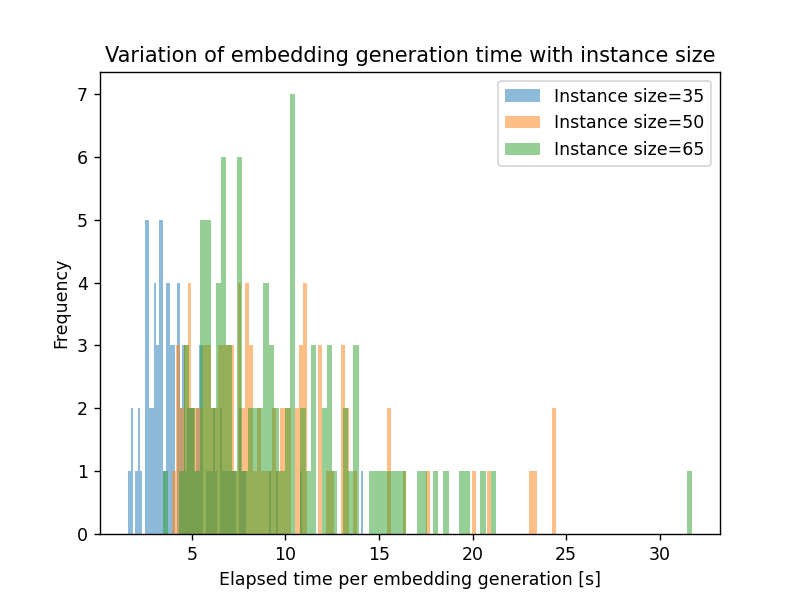

The maximum embedding time of instance size 50 is 24.47001838684082, for instance found in embedding 64
The minimum embedding time of instance size 50 is 3.961963415145874, for instance found in embedding 80
The maximum embedding time of instance size 65 is 31.715179443359375, for instance found in embedding 64
The minimum embedding time of instance size 65 is 3.4609997272491455, for instance found in embedding 39


In [18]:
# Variation of the embedding times with the instance size

%matplotlib notebook
for j in instance_sizes:
    
    instance_size=j
    embedding_time_list= np.loadtxt('embedding_time_list{}.csv'.format(instance_size), delimiter=',')
    embedding_time_list=list(embedding_time_list)
    max_time=max(embedding_time_list)
    index_max=embedding_time_list.index(max_time)
    min_time=min(embedding_time_list)
    index_min=embedding_time_list.index(min_time)    
    print('The maximum embedding time of instance size {} is {}, for instance found in embedding {}'.format(j,max_time,index_max))
    print('The minimum embedding time of instance size {} is {}, for instance found in embedding {}'.format(j,min_time,index_min))
    plt.hist(embedding_time_list, bins = embedding_number, label='Instance size={}'.format(instance_size), alpha=0.5)
    
plt.legend()
plt.title('Variation of embedding generation time with instance size')
plt.ylabel('Frequency')
plt.xlabel('Elapsed time per embedding generation [s]')
plt.show()

<IPython.core.display.Javascript object>


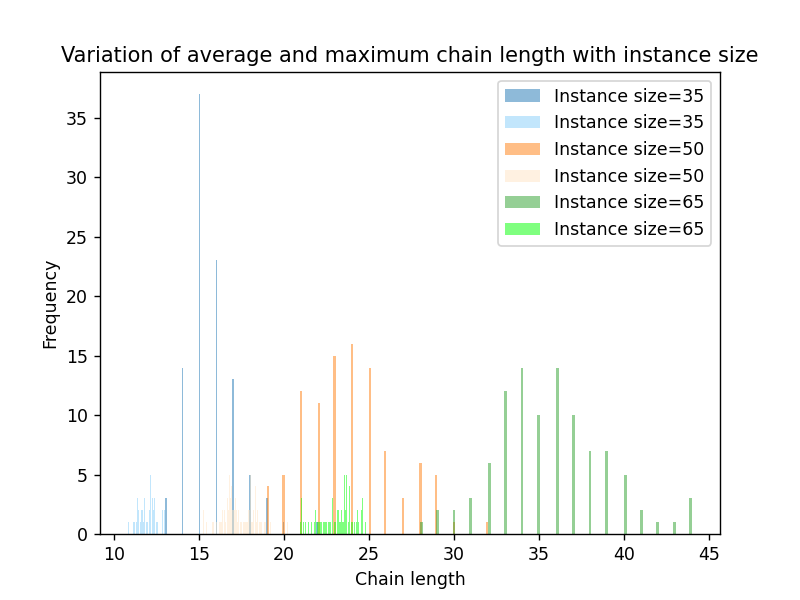

The max chain length in the generated embeddings (for an instance size of 35 binary variables) vary between  13 and  22 physical qubits
The max chain length in the generated embeddings (for an instance size of 50 binary variables) vary between  19 and  32 physical qubits
The max chain length in the generated embeddings (for an instance size of 65 binary variables) vary between  28 and  44 physical qubits


In [19]:
# Variation of the chain length statistics with the instance size

%matplotlib notebook

colors=['lightskyblue','bisque','lime']
max_chain_length_list = []
min_chain_length_list = []
avg_chain_length_list = []

instance_size=35

with open('embedded_graph_list{}.pkl'.format(instance_size), 'rb') as f:
        embedded_graph_list = pickle.load(f)

    
for i in range(embedding_number):
    max_chain_length = None
    min_chain_length = None
    avg_chain_length = 0

    for _, chain in embedded_graph_list[i].items():
        if max_chain_length is None:
            max_chain_length = len(chain)
            min_chain_length = len(chain)

        if len(chain) > max_chain_length:
            max_chain_length = len(chain)

        if len(chain) < min_chain_length:
            min_chain_length = len(chain)

        avg_chain_length += len(chain)

    avg_chain_length/= len(embedded_graph_list[i].items())

    max_chain_length_list.append(max_chain_length)
    min_chain_length_list.append(min_chain_length)
    avg_chain_length_list.append(avg_chain_length)

plt.hist(max_chain_length_list, bins = embedding_number, label="Instance size={}".format(instance_size), alpha=0.5)
plt.hist(avg_chain_length_list, bins = embedding_number, label="Instance size={}".format(instance_size),color=colors[0], alpha=0.5)

max_chain_length_list2 = []
min_chain_length_list2 = []
avg_chain_length_list2 = []


instance_size=50

with open('embedded_graph_list{}.pkl'.format(instance_size), 'rb') as f:
        embedded_graph_list = pickle.load(f)

    
for i in range(embedding_number):
    max_chain_length = None
    min_chain_length = None
    avg_chain_length = 0

    for _, chain in embedded_graph_list[i].items():
        if max_chain_length is None:
            max_chain_length = len(chain)
            min_chain_length = len(chain)

        if len(chain) > max_chain_length:
            max_chain_length = len(chain)

        if len(chain) < min_chain_length:
            min_chain_length = len(chain)

        avg_chain_length += len(chain)

    avg_chain_length/= len(embedded_graph_list[i].items())

    max_chain_length_list2.append(max_chain_length)
    min_chain_length_list2.append(min_chain_length)
    avg_chain_length_list2.append(avg_chain_length)

plt.hist(max_chain_length_list2, bins = embedding_number, label="Instance size={}".format(instance_size), alpha=0.5)
plt.hist(avg_chain_length_list2, bins = embedding_number, label="Instance size={}".format(instance_size),color=colors[1], alpha=0.5)


max_chain_length_list3 = []
min_chain_length_list3 = []
avg_chain_length_list3 = []
instance_size=65

with open('embedded_graph_list{}.pkl'.format(instance_size), 'rb') as f:
        embedded_graph_list = pickle.load(f)

    
for i in range(embedding_number):
    max_chain_length = None
    min_chain_length = None
    avg_chain_length = 0

    for _, chain in embedded_graph_list[i].items():
        if max_chain_length is None:
            max_chain_length = len(chain)
            min_chain_length = len(chain)

        if len(chain) > max_chain_length:
            max_chain_length = len(chain)

        if len(chain) < min_chain_length:
            min_chain_length = len(chain)

        avg_chain_length += len(chain)

    avg_chain_length/= len(embedded_graph_list[i].items())

    max_chain_length_list3.append(max_chain_length)
    min_chain_length_list3.append(min_chain_length)
    avg_chain_length_list3.append(avg_chain_length)

plt.hist(max_chain_length_list3, bins = embedding_number, label="Instance size={}".format(instance_size), alpha=0.5)
plt.hist(avg_chain_length_list3, bins = embedding_number, label="Instance size={}".format(instance_size),color=colors[2], alpha=0.5)



plt.legend()
plt.title('Variation of average and maximum chain length with instance size')
plt.ylabel('Frequency')
plt.xlabel('Chain length')

print('The max chain length in the generated embeddings (for an instance size of 35 binary variables) vary between ',min(max_chain_length_list),'and ', max(max_chain_length_list),'physical qubits')
print('The max chain length in the generated embeddings (for an instance size of 50 binary variables) vary between ',min(max_chain_length_list2),'and ', max(max_chain_length_list2),'physical qubits')
print('The max chain length in the generated embeddings (for an instance size of 65 binary variables) vary between ',min(max_chain_length_list3),'and ', max(max_chain_length_list3),'physical qubits')
 

<IPython.core.display.Javascript object>


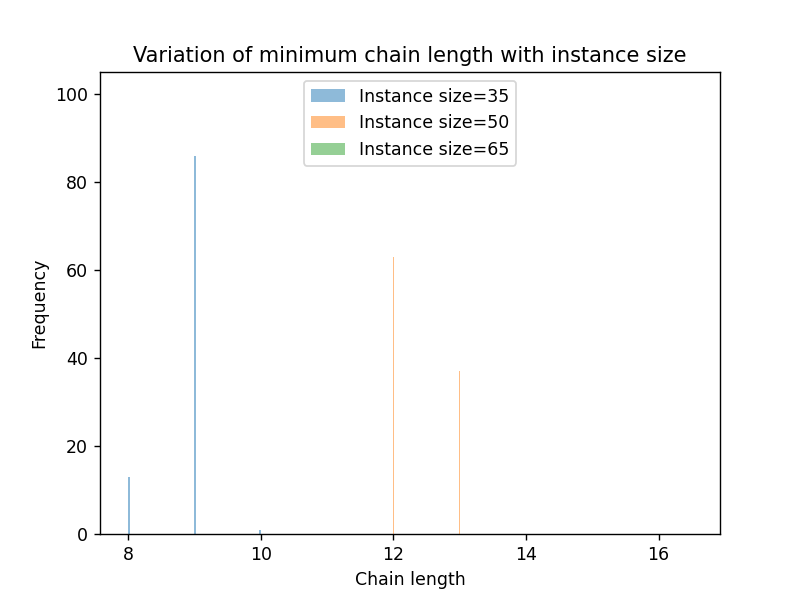

The min chain length in the generated embeddings (for an instance size of 35 binary variables) vary between  8 and  10 physical qubits
The min chain length in the generated embeddings (for an instance size of 50 binary variables) vary between  12 and  13 physical qubits
The min chain length in the generated embeddings (for an instance size of 65 binary variables) vary between  16 and  16 physical qubits


In [20]:
%matplotlib notebook

plt.hist(min_chain_length_list, bins = embedding_number, label="Instance size=35", alpha=0.5)
plt.hist(min_chain_length_list2, bins = embedding_number, label="Instance size=50", alpha=0.5)
plt.hist(min_chain_length_list3, bins = embedding_number, label="Instance size=65", alpha=0.5)

plt.legend()
plt.title('Variation of minimum chain length with instance size')
plt.ylabel('Frequency')
plt.xlabel('Chain length')
plt.show()

print('The min chain length in the generated embeddings (for an instance size of 35 binary variables) vary between ',min(min_chain_length_list),'and ', max(min_chain_length_list),'physical qubits')
print('The min chain length in the generated embeddings (for an instance size of 50 binary variables) vary between ',min(min_chain_length_list2),'and ', max(min_chain_length_list2),'physical qubits')
print('The min chain length in the generated embeddings (for an instance size of 65 binary variables) vary between ',min(min_chain_length_list3),'and ', max(min_chain_length_list3),'physical qubits')


# Minor-embedding selection for each instance size

It is possible to map the problem to a structured sampler using a ***specific minor-embedding***. For example it is possible to select the one with the lowest number of qubits (lower number/size of chains) from the previous 100 embeddings. Then this embedding can be enforced to the sampler using ***FixedEmbeddingComposite()***

In [5]:
instance_size=35 #[35,50,65]

with open('embedded_graph_list{}.pkl'.format(instance_size), 'rb') as f:
    embedded_graph_list = pickle.load(f)

embedding_time_list= np.loadtxt('embedding_time_list{}.csv'.format(instance_size), delimiter=',')

if instance_size==35:
    embedding_min_35=embedded_graph_list[20]

else:
    
    if instance_size==65:
        embedding_min_65=embedded_graph_list[99]

    else:
        embedding_min_50=embedded_graph_list[67]


# Visualization of smallest minor-embedding for each instance size

<IPython.core.display.Javascript object>


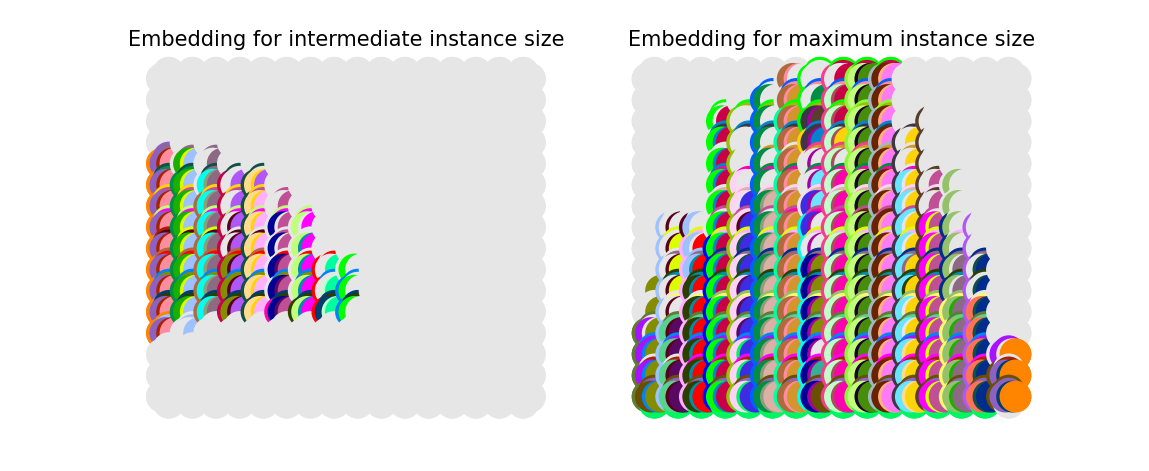

Text(0.5, 1.0, 'Embedding for maximum instance size')

In [14]:
%matplotlib notebook

# create figure
fig = plt.figure(figsize=(6,2))

# setting values to rows and column variables
rows = 1
columns = 2

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)

dnx.draw_chimera_embedding(C16,embedding_min_35, with_labels=False)
plt.title('Embedding for intermediate instance size') 


# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)

# plot this mebedding
dnx.draw_chimera_embedding(C16,embedding_min_65, with_labels=False)
plt.title('Embedding for maximum instance size') 


# Quantum Annealing for Non-negative/binary matrix factorization

 From here we start with the code for regarding the NBMF method

# Import facial images dataset and store it in matrix A. 


In [27]:
# Import dataset (Full size of matrix A is used only for Simulated Annealing Experiments)

f = h5py.File("faces.h5", "r")
A=np.array(f[("faces")])
print(A.shape)


(361, 2429)


# Image visualizer. Reshape A from 361x2429 array to 19x19x2429 array

<IPython.core.display.Javascript object>


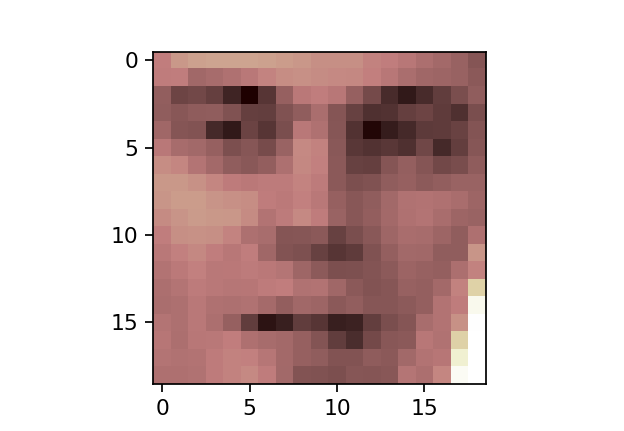

In [64]:
# Image visualizer. Reshape A from 361x2429 array to 19x19x2429 array
%matplotlib notebook

index=8 # from 0 to 2428
image_array_new=np.reshape(A,[19,19,2429]) 

rotated = sp.ndimage.rotate(image_array_new[:,:,index], -90)
plt.imshow(rotated, cmap= "pink")

# Definition of  functions

### Non-Negative Least Squares Problem for each row "Browi" of matrix B

In [19]:
# Non-Negative Least Squares Problem for each row "Browi" of matrix B

def solve_small_nnlsq(A,C,k,i,max_iter): 

    Arowi=np.reshape(A[i,:],[len(A[0,:]),1])#reshape ith row  of A as a column
    Browi0 = np.dot(np.linalg.pinv(C.T),Arowi) 
    Browi0=np.where(Browi0<0,0,Browi0)
    
    def objective(X):#definition of objective function to be solved using Nelder-Mead method
        f=0
        for j in range (0,len(A[0,:])):
            f+=(A[i,j]-sum(X[:]*C[:,j]))**2
        f+=1e-2*sum(X[:]**2)

        return f

    bnds = [(0, np.inf) for _ in range(Browi0.size)]
    sol=minimize(objective,Browi0, args=(), method='Nelder-Mead', jac=None, hess=None, hessp=None, bounds=bnds, constraints=(), tol=None, callback=None, options={ 'maxiter':max_iter})
    Browi=np.array(sol.x)
    
    return Browi

### Non-Negative Least Squares Problem-> Matrix B

In [18]:
# Non-Negative Least Squares Problem-> Matrix B. 
# Call function "solveBrowlsq" a number of times = number of rows of B to solve a "smaller" optimization problem of B

def solve_nnlsq(A,C,k,max_iter):
    
    B=np.zeros([len(A[:,0]),k])
    
    for i in range(len(A[:,0])):#361 len(A[:,0])
        start = time.time()
        Browi=solve_small_nnlsq(A,C,k,i,max_iter)
        B[i,:]=Browi.T
        end = time.time()
        print("B_row> ",i,", time> ",end-start)
        
    return B

### Setup of the Q matrix with dimension *kxk* 

In [17]:
def setup_small_qubo(A, B, j):
    Q = np.zeros([len(B[0,:]),len(B[0,:])])
    for k in range(0,len(B[0,:])):#0-34
        for i in range(0,len(A[:,0])):#0-361
            Q[k,k] += B[i,k] * (B[i, k] - 2 * A[i, j])
        for l in range(0,k):
            for i in range(0,len(A[:,0])):#0-361
                Q[k, l] += 2 * B[i, k] * B[i, l]
    return Q

### Function to print the best solution when using simulated annealing 

In [16]:
def best_sol_SA(response,Q,j):
    
    for read in response.aggregate().data(["energy", "num_occurrences"]):
        print(read)
        
    best_energy=np.inf    
    for sample, E in response.data(fields=['sample','energy']):      

        if E<best_energy:
            best_energy=E
            best_sample=sample

    ordered=[0] * len(Q[:,0]) 
    for i in range(len(Q[:,0])):
        index=int(list(best_sample.keys())[i])
        ordered[index]=list(best_sample.values())[i]
     
    print("The best solution for C[:,{}] has an energy of {}".format(j,best_energy))
    
    return ordered

### Function to print the best solution when using quantum annealing 

In [28]:
def best_sol_QA(response,Q,j):

    for read in response.aggregate().data(["energy", "num_occurrences", "chain_break_fraction"]):
        print(read)
    
    best_energy=np.inf    
    for sample, E, chain_break_fraction in response.data(fields=['sample','energy','chain_break_fraction']):      

        if E<best_energy and chain_break_fraction==0: # here we enforce that no broken chain be accepted as best solution
            best_energy=E
            best_sample=sample

    ordered=[0] * len(Q[:,0]) 
    for i in range(len(Q[:,0])):
        index=int(list(best_sample.keys())[i])
        ordered[index]=list(best_sample.values())[i]
        
    print("The best solution for C[:,{}] has an energy of {}".format(j,best_energy))
    
    return ordered

### Function to print the best solution when using quantum annealing to provide the first classical state for the reverse annealing schedule

In [24]:
def forward_sol(response,Q,j):
    
    for read in response.aggregate().data(["energy", "num_occurrences", "chain_break_fraction"]):
        print(read)
        
    best_energy=np.inf
    for sample, E in response.data(fields=['sample','energy']):      

        if E<best_energy:
            best_energy=E
            best_sample=sample

    ordered=[0] * len(Q[:,0])
    for i in range(len(Q[:,0])):
        index=int(list(best_sample.keys())[i])
        ordered[index]=list(best_sample.values())[i]
    print("The forward annealing solution for C[:,{}] has an energy of {}".format(j,best_energy))

    return ordered

### Function to sample the QPU device under default annealing schedule

In [23]:
def DWave_Sampler(Q,num_reads,j,k):
    import time
    print("DWave_Sampler, QUBO>",j)
    
    if k==35:
        sampler = FixedEmbeddingComposite(DWaveSampler(solver={'topology__type': 'chimera'}),embedding_min_35)
    else:
        sampler = FixedEmbeddingComposite(DWaveSampler(solver={'topology__type': 'chimera'}),embedding_min_65)
    chain_strength = 10
    response_DW = sampler.sample_qubo(Q,num_reads = num_reads,chain_strength =chain_strength,return_embedding=True)
    time=response_DW.info["timing"]['qpu_access_time']
    print(response_DW.info["timing"])
    
    return response_DW,time

### Function to sample the QPU device under extended annealing time schedule

In [22]:
def DWave_Sampler_annealing_time(Q,num_reads,j,k):
    import time
    print("DWave_Sampler, QUBO>",j)
    if k==35:
        sampler = FixedEmbeddingComposite(DWaveSampler(solver={'topology__type': 'chimera'}),embedding_min_35)
    else:
        sampler = FixedEmbeddingComposite(DWaveSampler(solver={'topology__type': 'chimera'}),embedding_min_65)
    chain_strength = 10
    long_time = DWaveSampler().properties["annealing_time_range"][1]/20
    response_DW = sampler.sample_qubo(Q,num_reads = num_reads,chain_strength =chain_strength,return_embedding=True,annealing_time=long_time)
    time=response_DW.info["timing"]['qpu_access_time']
    print(response_DW.info["timing"])
    
    return response_DW,time

### Function to sample the QPU device under pause/quench annealing schedule

In [21]:
def DWave_Sampler_pause_quench(Q,num_reads,j,k):
    import time
    print("DWave_Sampler, QUBO>",j)
    if k==35:
        sampler = FixedEmbeddingComposite(DWaveSampler(solver={'topology__type': 'chimera'}),embedding_min_35)
    else:
        sampler = FixedEmbeddingComposite(DWaveSampler(solver={'topology__type': 'chimera'}),embedding_min_65)
    chain_strength = 10
    anneal_schedule = [[0.0, 0.0], [10, 0.5], [99, 0.5], [100, 1.0]]
    response_DW = sampler.sample_qubo(Q,num_reads = num_reads,chain_strength =chain_strength,return_embedding=True,anneal_schedule=anneal_schedule)
    time=response_DW.info["timing"]['qpu_access_time']
    print(response_DW.info["timing"])
    
    return response_DW,time

### Function to sample the QPU device under reverse annealing schedule

In [16]:
def Reverse_Annealing_Schedule(t,r):
    # r is the reversal distance 
    # t is the reversal time spent at r (microseconds)
    #schedule is formatted as a list of [time, s] pairs, in which time is in microseconds and s is "temperature" (unitless) the normalized persistent current in the range [0,1]
    schedule=[[0,1.0],[10,1-r],[10+t, 1-r],[20+t, 1]]
    
    return schedule

### Function to sample using simulated annealing

In [15]:
def Simulated_Annealing(Q,num_reads,j):
    import time
    print("Simulated_Annealing, QUBO>",j)
    sampler = SimulatedAnnealingSampler()
    start = time.time()
    response_SA = sampler.sample_qubo(Q,num_reads = num_reads)
    end = time.time()
    time=end-start
    
    return response_SA,time

### Function to generate the histogram of the energies of a given solution

In [76]:
def histogram_energies(Energies,iteration,QUBO):
    %matplotlib notebook

    for i in range(len(Energies)):
        bins=100
        plt.hist(Energies[i], bins= bins, alpha=0.5)

    plt.title("Distribution of the energies of the randomly chosen QUBO{} from iteration{}".format(QUBO,iteration))
    plt.xlabel("Energy of the sample")
    plt.ylabel("Frequency")
    plt.show()
    plt.savefig('Distribution of the energies QUBO{}_ITER{}.png'.format(QUBO,iteration))
    plt.close()

### Function to generate the histogram of the chain break fractions of a given solution

In [77]:
def histogram_chain_brake(Chain_break_fractions,iteration,QUBO):
    %matplotlib notebook
    
    for i in range(len(Chain_break_fractions)):
        bins=100
        plt.hist(Chain_break_fractions[i], bins= bins, alpha=0.5)
        
    plt.title("Distribution of the chain break fraction of the randomly chosen QUBO{} from iteration{}".format(QUBO,iteration))
    plt.xlabel("Chain break fraction of the sample")
    plt.ylabel("Frequency")
    plt.show()
    plt.savefig('Chain break fraction QUBO{}_ITER{}.png'.format(QUBO,iteration))
    plt.close()

## Random seed function and random number visualizer

In [49]:
# Simulated annealing experiments
np.random.seed(0)
a=np.random.randint(0,2429,dtype=int)
print(a)


1653


In [79]:
# Quantum annealing experiments
np.random.seed(2)
a=np.random.randint(0,2429,dtype=int)
b=np.random.randint(0,100,dtype=int)
c=np.random.randint(0,100,dtype=int)
d=np.random.randint(0,100,dtype=int)

print(a)
print(b)
print(c)
print(d)


1608
22
43
82


### Binary Least Squares Problem -> Matrix C

### Cases selector

In [26]:
# Binary Least Squares Problem -> Matrix C
def solve_small_blsq(i,iters,cumulative_time,cumulative_Q_time,case,k,A, B,C_old,num_reads=1,num_reads_rev=1, t=0, r=0):
    
    np.random.seed(2)
    a=np.random.randint(0,2429,dtype=int)
    b=np.random.randint(0,100,dtype=int)
    c=np.random.randint(0,100,dtype=int)
    d=np.random.randint(0,100,dtype=int)
    Energies=[]
    Chain_break_fractions=[]
    C = np.zeros([len(B[0,:]), len(A[0,:])], dtype='int8')
      
    for j in range(len(A[0,:])):# 2429 len(A[0,:])
        import time
        
        start = time.time()
        Q = setup_small_qubo(A, B, j)  
        cumulative_Q_time += time.time()-start
        print('Cumulative time assembling Q matrix [seconds]',cumulative_Q_time)
        
        if case==1:
            
            response,time=Simulated_Annealing(Q,num_reads,j)
            cumulative_time+=time
            print('Cumulative annealing time [seconds]',cumulative_time)
            C[:,j]=best_sol_SA(response,Q,j)
            
            if i==1 or i==7 or i== iters:# save the energy distribution of the samples for initial, middle and final iterations              
                if j==b or j==c or j==d:# randomly chosen QUBOs using np.random.seed(2) = (22,43,82)
                    Energies.append(response.record.energy)
                    plot_distributions(case,Energies,Chain_break_fractions,i,j)
                    Energies=[]
                
        if case==2:
            
            response,time=DWave_Sampler(Q,num_reads,j,k)
            cumulative_time+=time
            print('Cumulative annealing time [microseconds]',cumulative_time)
            C[:,j]= best_sol_QA(response,Q,j)
            if i==1 or i==7 or i== iters:# save the energy distribution and chain break fractions of the samples for initial, middle and final iterations
                if j==b or j==c or j==d:# randomly chosen QUBOs using np.random.seed(2) = (22,43,82)
                    Energies.append(response.record.energy)
                    Chain_break_fractions.append(response.record.chain_break_fraction)
                    plot_distributions(case, Energies,Chain_break_fractions,i,j)
                    Energies=[]
                    Chain_break_fractions=[]
            
        if case==3:
            
            
            if i==1:
                print("Single forward annealing")
                forward_response,time=DWave_Sampler(Q,1,j,k)
                cumulative_time+=time
                print('Cumulative annealing time (after forward annealing)[microseconds]',cumulative_time)
                
                #Initial state from single forward annealing on first iteration
                initial= forward_sol(forward_response,Q,j)
                initial={i:int(initial[i]) for i in range(len(C[:,j]))}

            else:
                #Initial state for all other iterations
                initial= {i:int(C_old[i,j]) for i in range(len(C_old[:,j]))}

            #Reverse_Annealing_Schedule
            reverse_schedule=Reverse_Annealing_Schedule(t=t,r=r)
    
            print("Reverse Annealing") 
            chain_strength = 10
            if k==35:
                sampler = FixedEmbeddingComposite(DWaveSampler(solver={'topology__type': 'chimera'}),embedding_min_35)
            else:
                sampler = FixedEmbeddingComposite(DWaveSampler(solver={'topology__type': 'chimera'}),embedding_min_65)
            
            reverse_anneal_params = dict(anneal_schedule=reverse_schedule, initial_state=initial, reinitialize_state=True)
            
            reverse_response = sampler.sample_qubo(Q, num_reads=num_reads_rev,chain_strength = chain_strength, **reverse_anneal_params)
            cumulative_time+=reverse_response.info["timing"]['qpu_access_time']
            print(reverse_response.info["timing"])
            print('Cumulative annealing time (after reverse annealing)[microseconds]',cumulative_time)
            C[:,j]= best_sol_QA(reverse_response,Q,j)
            if i==1 or i==7 or i== iters:# save the energy distribution and chain break fractions of the samples for initial, middle and final iterations
                if j==b or j==c or j==d:# randomly chosen QUBOs using np.random.seed(2) = (22,43,82)
                    Energies.append(reverse_response.record.energy)
                    Chain_break_fractions.append(reverse_response.record.chain_break_fraction)
                    plot_distributions(case, Energies,Chain_break_fractions,i,j)
                    Energies=[]
                    Chain_break_fractions=[]
                    
        if case==4:
            
            response,time=DWave_Sampler_annealing_time(Q,num_reads,j,k)
            cumulative_time+=time
            print('Cumulative annealing time [microseconds]',cumulative_time)
            C[:,j]= best_sol_QA(response,Q,j)
            if i==1 or i==7 or i== iters:
                if j==b or j==c or j==d:
                    Energies.append(response.record.energy)
                    Chain_break_fractions.append(response.record.chain_break_fraction)
                    plot_distributions(case, Energies,Chain_break_fractions,i,j)
                    Energies=[]
                    Chain_break_fractions=[]
                    
        if case==5:
            
            response,time=DWave_Sampler_pause_quench(Q,num_reads,j,k)
            cumulative_time+=time
            print('Cumulative annealing time [microseconds]',cumulative_time)
            C[:,j]= best_sol_QA(response,Q,j)
            if i==1 or i==7 or i== iters:
                if j==b or j==c or j==d:
                    Energies.append(response.record.energy)
                    Chain_break_fractions.append(response.record.chain_break_fraction)  
                    plot_distributions(case, Energies,Chain_break_fractions,i,j)
                    Energies=[]
                    Chain_break_fractions=[]
    
    return C,cumulative_time,cumulative_Q_time

### Function to determine if we need to generate the histogram of energies only or both energies and chain break fractions

In [27]:
def plot_distributions(case, Energies,Chain_break_fractions,iteration,QUBO):
    #Plot energy distributions and chain break fraction of selected iteration and QUBOs  
    if case==1:
        histogram_energies(Energies,iteration,QUBO)
    else:
        histogram_energies(Energies,iteration,QUBO)
        histogram_chain_brake(Chain_break_fractions,iteration,QUBO)

### Function controllnig the overall algorithm of the NBMF method.
### This function receives the parameters from the Main function 

In [28]:
# Main function

def factorization(case,A,k=1,iters=1,max_iter=1,num_reads=1,num_reads_rev=1,t=0,r=0):
    
    import time
    start_time = time.time()
    B=np.random.random((len(A[:,0]),k))
    C=np.random.choice([0,1],size=[k,(len(A[0,:]))])
    C_old=C
    Energies=[]
    Chain_break_fractions=[]
    cumulative_time=0
    cumulative_Q_time=0
    
#     A=BC [nxm]
#     B - Non-Negative Matrix [nxk]
#     C - Sparse Binary Matrix [kxm]
    
    tnnlsq_iter=[0]*iters
    tblsq_iter=[0]*iters
    ChangeB=[0]*iters
    ChangeC=[0]*iters
    last_norm=np.inf
    best_norm=np.inf
    relative_errors=[0]*iters
                         
    for i in range (1,iters+1): 
        print("\nGlobal iteration: ", i)
        import time
        #---------------------------------------------------B------------------------------------------------------------
        
        B_ini=B # initialize B
        start = time.time()
        B = solve_nnlsq(A,C,k,max_iter)# Solve matrix B
        end = time.time()
        tnnlsq= end - start# time for first subroutine at iteration i> solution  matrix B
        tnnlsq_iter[i-1]= tnnlsq #list of times solution matrix B
        
        B_new=B #update matrix B
        np.savetxt('B_iter{}_{}.csv'.format(i,case), B, delimiter=',')#save matrix B at iteration i       
      
        Change_B=np.linalg.norm(B_new-B_ini)/np.linalg.norm(B_ini)# % Change in B  
        print("%Change in B = ||Bi+1-Bi||/||Bi|| of between iteration {} and {} is {}".format(i-1,i,Change_B))
        ChangeB[i-1]=Change_B # save % Change in B in list
        
        
        #------------------------------------------------------C--------------------------------------------------------
        
        C_ini=C # initialize C
        
        # Solve matrix C
        start = time.time()
        C,cumulative_time,cumulative_Q_time= solve_small_blsq(i,iters,cumulative_time,cumulative_Q_time,case,k,A, B,C_old,num_reads=num_reads,num_reads_rev=num_reads_rev,t=t,r=r)
        end = time.time()
        C_old=C
        tblsq= end - start# time for second subroutine at iteration i> solution  matrix C
        tblsq_iter[i-1]= tblsq #list of times solution matrix C
        
        C_new=C #update matrix C
        np.savetxt('C_iter{}_{}.csv'.format(i,case), C, delimiter=',')#save matrix C at iteration i  
        
        Change_C=np.count_nonzero(C_ini!=C_new)/(k*(len(A[0,:])))# % Change in C
        print("%Change in C = Hamming distance between Ci+1-Ci/size C, between iteration {} and {} is {}".format(i-1,i,Change_C))
        ChangeC[i-1]=Change_C # save % Change in C in list
        
              

        #------------------------------------------- Check and update best solutions for B,C  --------------------------------------
        
        this_norm=np.linalg.norm(A-np.dot(B,C))
        relative_errors[i-1]=np.linalg.norm(this_norm)/np.linalg.norm(A) # Define relative error
        print("Finished iteration {} with a relative error ||A-B*C||/||A|| of {}".format(i, np.linalg.norm(this_norm)/np.linalg.norm(A)))           
                
        if this_norm<best_norm:
            
            bestB=B
            bestC=C
            best_norm= this_norm
            
        last_norm=this_norm
        
        
        end_time = time.time()
        total_execution_time=end_time-start_time
        
        #Save information every iteration 
        # Save best global solution of B and C    
        savetxt('BestB_tot_it_{}_{}.csv'.format(iters,case), bestB, delimiter=',')
        savetxt('BestC_tot_it_{}_{}.csv'.format(iters,case), bestC, delimiter=',')
        # Save % Change of B and C at each iteration
        savetxt('%ChangeB_tot_it_{}_{}.csv'.format(iters,case), ChangeB, delimiter=',')
        savetxt('%ChangeC_tot_it_{}_{}.csv'.format(iters,case), ChangeC, delimiter=',')
        # Save evolution of relative error
        savetxt('relative_errors_tot_it_{}_{}.csv'.format(iters,case), relative_errors, delimiter=',')
        # Save individual times of both subroutines at each iteration
        savetxt('tnnlsq_iter_tot_it_{}_{}.csv'.format(iters,case), tnnlsq_iter, delimiter=',')
        savetxt('tblsq_iter_tot_it_{}_{}.csv'.format(iters,case), tblsq_iter, delimiter=',')
        
        # Print times
        print('\nTotal execution time [s]: ',total_execution_time)
        if case==1:
            print('Total annealing time [s]: ',cumulative_time)
        else:
            print('Total annealing time [s]: ',cumulative_time/1e6)  
        print('Total Q matrix assembling time [s]: ',cumulative_Q_time)

        # Save times
        with open('Cummulative_annealing_time_case{}.txt'.format(case), 'w') as f:
            if case==1:
                f.write(str(cumulative_time))
            else:
                f.write(str(cumulative_time/1e6))

        with open('Total_execution_time_case{}.txt'.format(case), 'w') as f:
            f.write(str(total_execution_time))

        with open('Cummulative_Q_matrix_assembling_time_case{}.txt'.format(case), 'w') as f:
            f.write(str(cumulative_Q_time))
    
    
    return bestB, bestC, ChangeB,ChangeC,relative_errors,cumulative_time,cumulative_Q_time

# Annealing schedules visualization

<IPython.core.display.Javascript object>


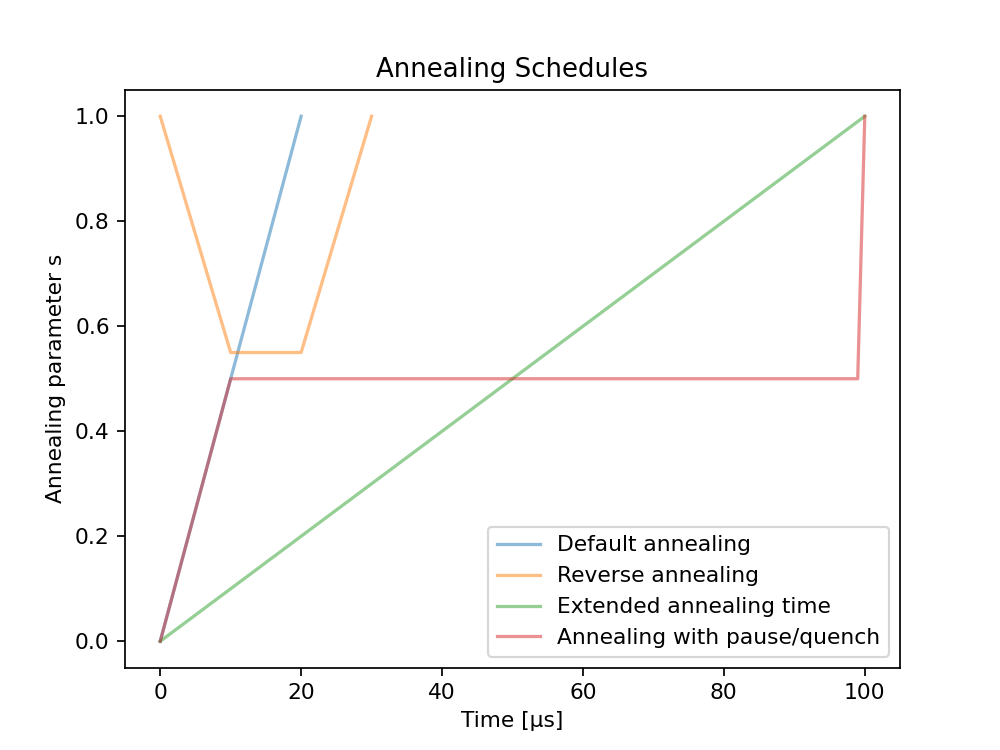

In [30]:
fig, ax = plt.subplots() 
ax.plot([0,20],[0,1],  label='Default annealing',alpha=0.5)
ax.plot([0,10,20,30],[1,0.55,0.55,1],  label='Reverse annealing ',alpha=0.5)
ax.plot([0,100],[0,1],  label='Extended annealing time',alpha=0.5)
ax.plot([0,10,99,100],[0,0.5,0.5,1],  label='Annealing with pause/quench',alpha=0.5)
ax.set(xlabel='Time [\u03BCs]', ylabel='Annealing parameter s', title='Annealing Schedules')
plt.legend()
plt.show()
fig.savefig("schedules.png")

# Main function: Case selection

### Cases

 1:Simulated Annealing 
 
 2:Quantum Annealing using default annealing time=20 us
 
 3:Reverse Annealing using t=10,r=0.45
 
 4:Quantum Annealing using extended annealing time=100 us
 
 5:Quantum Annealing using pause/quench schedule

In [ ]:

A=A[:,0:100]# Reduced version of matrix A

#CASE SELECTION!!
case=3

if case ==1: # SA
    num_reads=100
if case ==2: # Forward annealing
    num_reads=128
if case ==3: # Reverse annealing 
    num_reads=55
if case ==4: # Forward annealing with annealing time=100 us
    num_reads=96
if case ==5: # Annealing schedule with pause/quench
    num_reads=96


bestB,bestC,ChangeB,ChangeC,relative_errors,cumulative_time,cumulative_Q_time=factorization(case,A,k=35,iters=14,max_iter=1000,num_reads=num_reads,num_reads_rev=num_reads,t=10,r=0.45)



# Post-processing

## Visualization of matrix A, reconstructed matrix BC and error

Here you can select the specific case, in order to check already available results

<IPython.core.display.Javascript object>


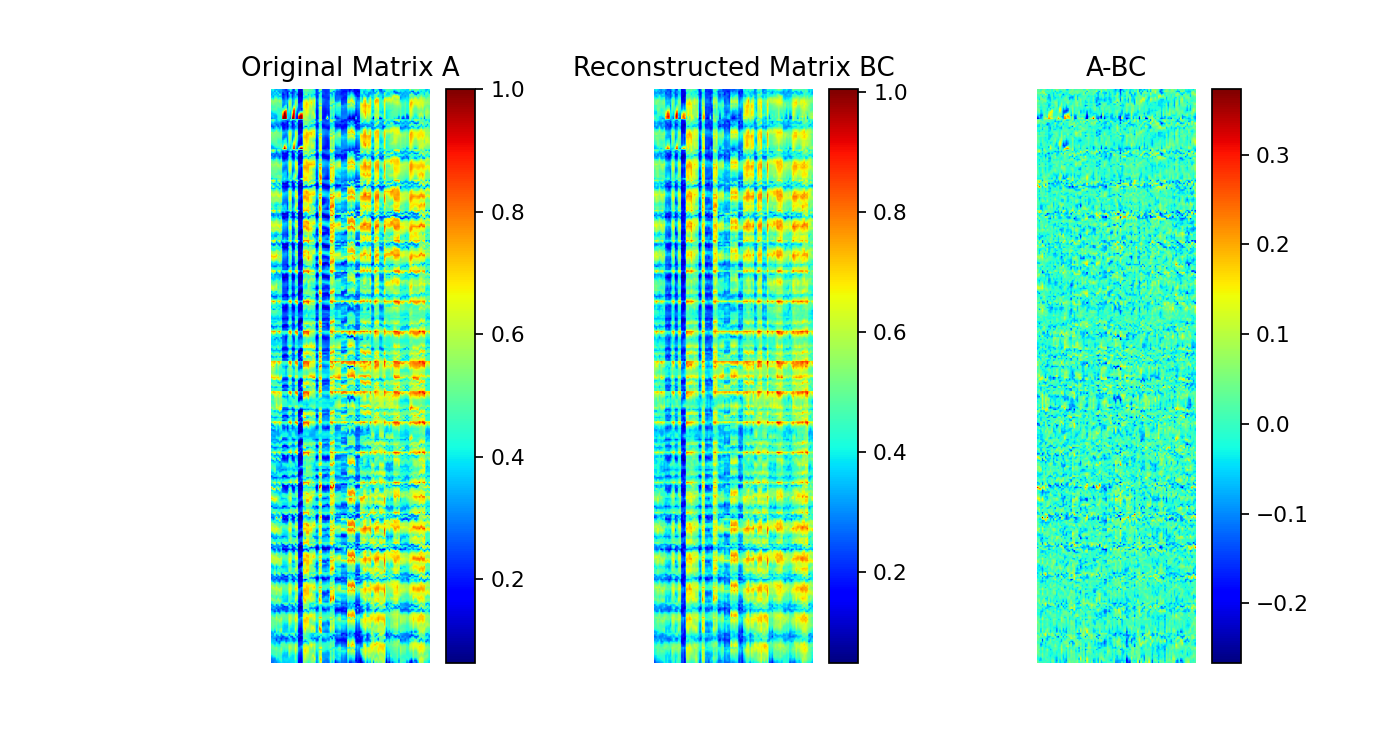

(-0.5, 99.5, 360.5, -0.5)

In [21]:
#CASE SELECTION!!!
case=3

A=A[:,0:100]# Reduced version of matrix A

%matplotlib notebook
bestB= np.loadtxt('BestB_tot_it_14_{}.csv'.format(case), delimiter=',')
bestC= np.loadtxt('BestC_tot_it_14_{}.csv'.format(case), delimiter=',')

fig = plt.figure()
    
fig.add_subplot(1, 3, 1)
plt.title('Original Matrix A')
plt.imshow(A, cmap='jet')
plt.colorbar()
plt.axis('off')


fig.add_subplot(1, 3, 2)
plt.title('Reconstructed Matrix BC')
plt.imshow(np.dot(bestB,bestC), cmap='jet')
plt.colorbar()
plt.axis('off')


fig.add_subplot(1, 3, 3)
plt.title('A-BC')
plt.imshow(A-np.dot(bestB,bestC), cmap='jet')
plt.colorbar()
plt.axis('off')



## Original vs. Reconstructed facial images visualization

54
70
59
53
41
63
43
88
95


<IPython.core.display.Javascript object>


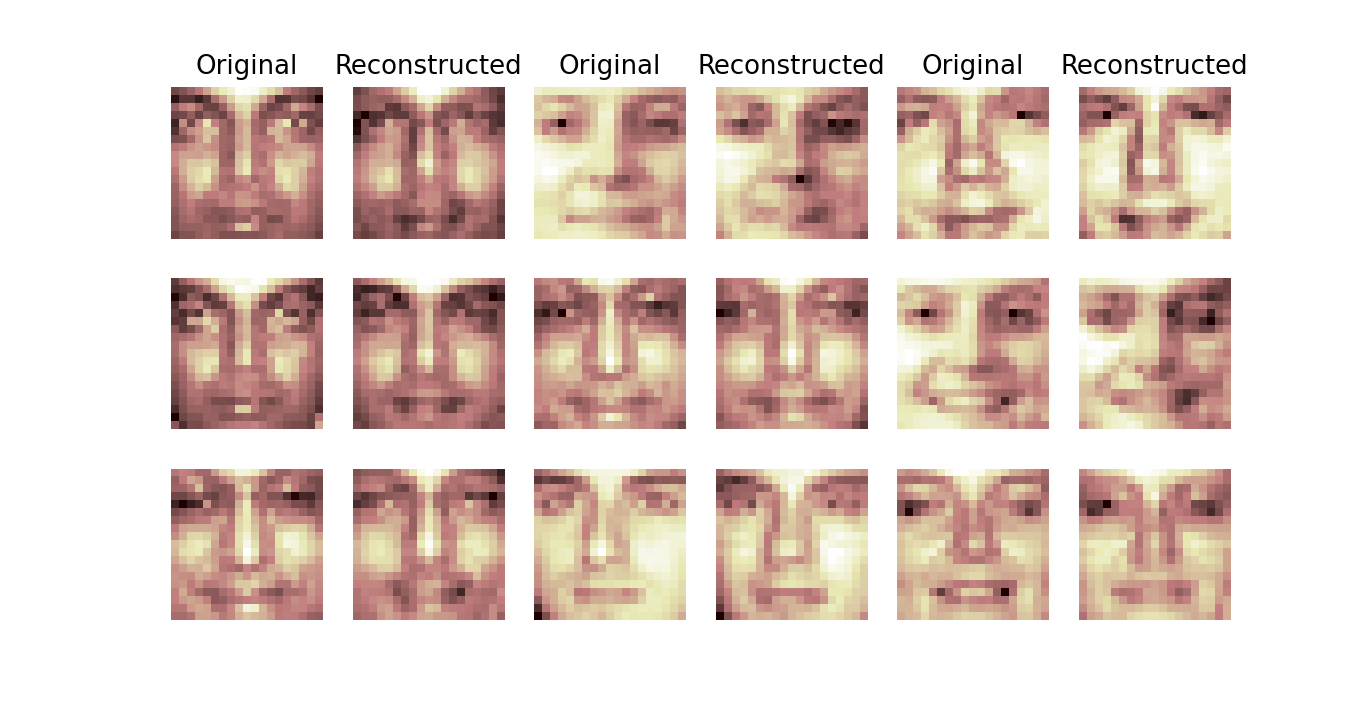

In [22]:
bestB = np.loadtxt('BestB_tot_it_14_{}.csv'.format(case), delimiter=',')
bestC = np.loadtxt('BestC_tot_it_14_{}.csv'.format(case), delimiter=',')


np.random.seed(0)
dataset_size=100


# Image visualizer. Reshape A from 361x2429 array to 19x19x2429 array

index1=int(np.random.random()*(dataset_size-1)) 
index2=int(np.random.random()*(dataset_size-1))
index3=int(np.random.random()*(dataset_size-1))
print(index1)
print(index2)
print(index3)

image_array_new=np.reshape(A,[19,19,dataset_size]) 
%matplotlib notebook
image1 = sp.ndimage.rotate(image_array_new[:,:,index1], -90)

image_array_new=np.reshape(np.dot(bestB,bestC),[19,19,dataset_size]) 
%matplotlib notebook
image2 = sp.ndimage.rotate(image_array_new[:,:,index1], -90)

image_array_new=np.reshape(A,[19,19,dataset_size]) 
%matplotlib notebook
image3 = sp.ndimage.rotate(image_array_new[:,:,index2], -90)

image_array_new=np.reshape(np.dot(bestB,bestC),[19,19,dataset_size]) 
%matplotlib notebook
image4 = sp.ndimage.rotate(image_array_new[:,:,index2], -90)

image_array_new=np.reshape(A,[19,19,dataset_size]) 
%matplotlib notebook
image5 = sp.ndimage.rotate(image_array_new[:,:,index3], -90)

image_array_new=np.reshape(np.dot(bestB,bestC),[19,19,dataset_size]) 
%matplotlib notebook
image6 = sp.ndimage.rotate(image_array_new[:,:,index3], -90)

# ------------------------------------------------------
index4=int(np.random.random()*(dataset_size-1)) 
index5=int(np.random.random()*(dataset_size-1))
index6=int(np.random.random()*(dataset_size-1))
print(index4)
print(index5)
print(index6)

image_array_new=np.reshape(A,[19,19,dataset_size]) 
%matplotlib notebook
image7 = sp.ndimage.rotate(image_array_new[:,:,index4], -90)

image_array_new=np.reshape(np.dot(bestB,bestC),[19,19,dataset_size]) 
%matplotlib notebook
image8 = sp.ndimage.rotate(image_array_new[:,:,index4], -90)

image_array_new=np.reshape(A,[19,19,dataset_size]) 
%matplotlib notebook
image9 = sp.ndimage.rotate(image_array_new[:,:,index5], -90)

image_array_new=np.reshape(np.dot(bestB,bestC),[19,19,dataset_size]) 
%matplotlib notebook
image10 = sp.ndimage.rotate(image_array_new[:,:,index5], -90)

image_array_new=np.reshape(A,[19,19,dataset_size]) 
%matplotlib notebook
image11 = sp.ndimage.rotate(image_array_new[:,:,index6], -90)

image_array_new=np.reshape(np.dot(bestB,bestC),[19,19,dataset_size]) 
%matplotlib notebook
image12 = sp.ndimage.rotate(image_array_new[:,:,index6], -90)

# ------------------------------------------------------
index7=int(np.random.random()*(dataset_size-1)) 
index8=int(np.random.random()*(dataset_size-1))
index9=int(np.random.random()*(dataset_size-1))
print(index7)
print(index8)
print(index9)

image_array_new=np.reshape(A,[19,19,dataset_size]) 
%matplotlib notebook
image13 = sp.ndimage.rotate(image_array_new[:,:,index7], -90)

image_array_new=np.reshape(np.dot(bestB,bestC),[19,19,dataset_size]) 
%matplotlib notebook
image14 = sp.ndimage.rotate(image_array_new[:,:,index7], -90)

image_array_new=np.reshape(A,[19,19,dataset_size]) 
%matplotlib notebook
image15 = sp.ndimage.rotate(image_array_new[:,:,index8], -90)

image_array_new=np.reshape(np.dot(bestB,bestC),[19,19,dataset_size]) 
%matplotlib notebook
image16 = sp.ndimage.rotate(image_array_new[:,:,index8], -90)

image_array_new=np.reshape(A,[19,19,dataset_size]) 
%matplotlib notebook
image17 = sp.ndimage.rotate(image_array_new[:,:,index9], -90)

image_array_new=np.reshape(np.dot(bestB,bestC),[19,19,dataset_size]) 
%matplotlib notebook
image18 = sp.ndimage.rotate(image_array_new[:,:,index9], -90)

# ------------------------------------------------------

# create figure
fig = plt.figure(figsize=(3,3))

# setting values to rows and column variables
rows = 3
columns = 6


fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(image1, cmap= "pink")
plt.axis('off')
plt.title("Original")


fig.add_subplot(rows, columns, 2)

# showing image
plt.imshow(image2, cmap= "pink")
plt.axis('off')
plt.title("Reconstructed")


fig.add_subplot(rows, columns, 3)

# showing image
plt.imshow(image3, cmap= "pink")
plt.axis('off')
plt.title("Original")


fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(image4, cmap= "pink")
plt.axis('off')
plt.title("Reconstructed")


fig.add_subplot(rows, columns, 5)

# showing image
plt.imshow(image5, cmap= "pink")
plt.axis('off')
plt.title("Original")


fig.add_subplot(rows, columns, 6)

# showing image
plt.imshow(image6, cmap= "pink")
plt.axis('off')
plt.title("Reconstructed")

#--------------------------------------------

fig.add_subplot(rows, columns, 7)

# showing image
plt.imshow(image7, cmap= "pink")
plt.axis('off')
# plt.title("Original")


fig.add_subplot(rows, columns, 8)

# showing image
plt.imshow(image8, cmap= "pink")
plt.axis('off')
# plt.title("Reconstructed")

# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 9)

# showing image
plt.imshow(image9, cmap= "pink")
plt.axis('off')
# plt.title("Original")


fig.add_subplot(rows, columns, 10)

# showing image
plt.imshow(image10, cmap= "pink")
plt.axis('off')
# plt.title("Reconstructed")


fig.add_subplot(rows, columns, 11)

# showing image
plt.imshow(image11, cmap= "pink")
plt.axis('off')
# plt.title("Original")


fig.add_subplot(rows, columns, 12)

# showing image
plt.imshow(image12, cmap= "pink")
plt.axis('off')
# plt.title("Reconstructed")

#---------------------------------

fig.add_subplot(rows, columns, 13)

# showing image
plt.imshow(image13, cmap= "pink")
plt.axis('off')
# plt.title("Original")


fig.add_subplot(rows, columns, 14)

# showing image
plt.imshow(image14, cmap= "pink")
plt.axis('off')
# plt.title("Reconstructed")


fig.add_subplot(rows, columns, 15)

# showing image
plt.imshow(image15, cmap= "pink")
plt.axis('off')
# plt.title("Original")


fig.add_subplot(rows, columns, 16)

# showing image
plt.imshow(image16, cmap= "pink")
plt.axis('off')
# plt.title("Reconstructed")


fig.add_subplot(rows, columns, 17)

# showing image
plt.imshow(image17, cmap= "pink")
plt.axis('off')
# plt.title("Original")


fig.add_subplot(rows, columns, 18)

# showing image
plt.imshow(image18, cmap= "pink")
plt.axis('off')
# plt.title("Reconstructed")


plt.show()

# Extracted feature vectors visualization

<IPython.core.display.Javascript object>


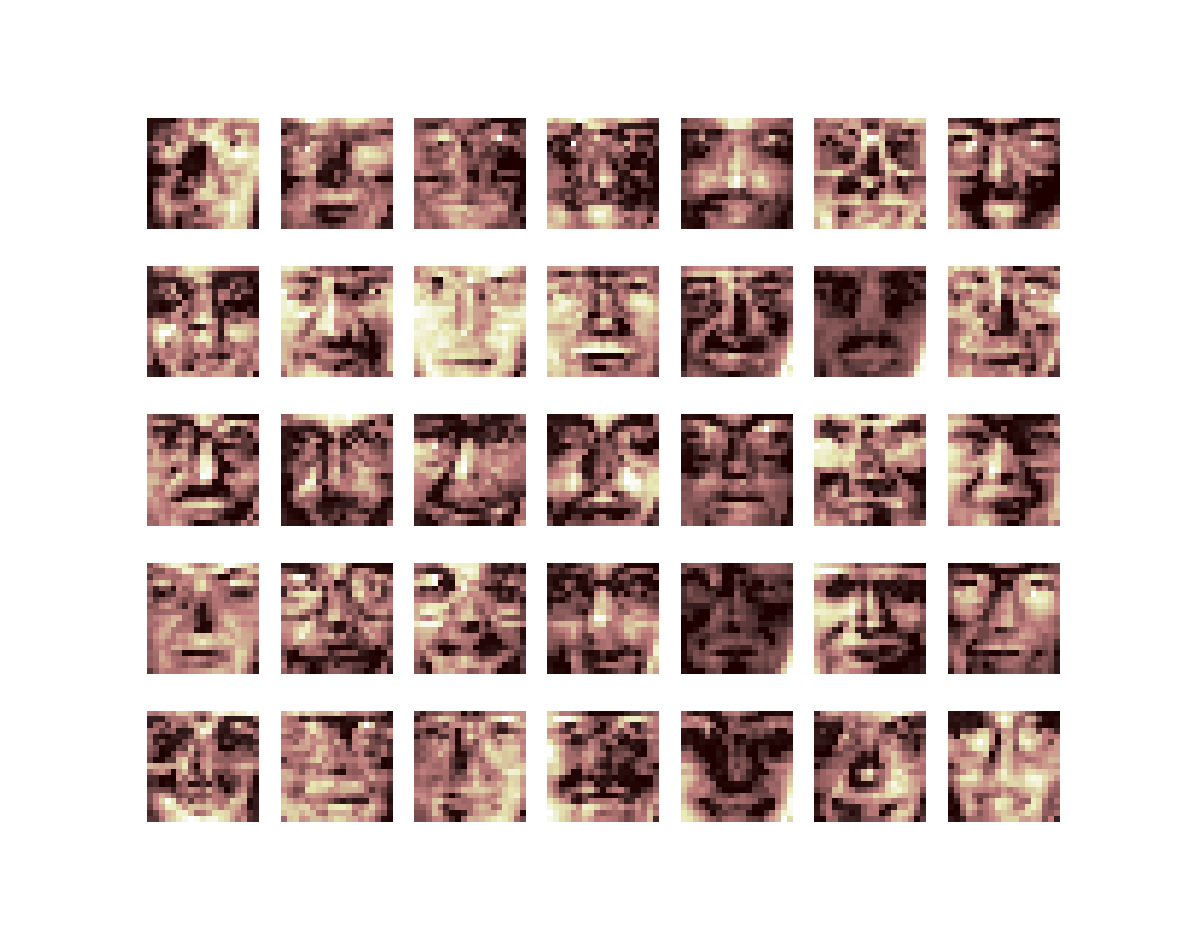

In [23]:
bestB = np.loadtxt('BestB_tot_it_14_{}.csv'.format(case), delimiter=',')

# Image visualizer. Reshape A from 361x2429 array to 19x19x2429 array
dataset_size=35 # from 0 to 2428

image_array_new=np.reshape(bestB,[19,19,dataset_size]) 
%matplotlib notebook


# create figure
fig = plt.figure(figsize=(3,3))

# setting values to rows and column variables
rows =5
columns = 7

for i in range(rows):
    for j in range(columns):
        fig.add_subplot(rows, columns, 7*i+j+1)
        plt.imshow(sp.ndimage.rotate(image_array_new[:,:,7*i+j], -90), cmap= "pink")
        plt.axis('off')
plt.show()

# Relative error evolution 

<IPython.core.display.Javascript object>


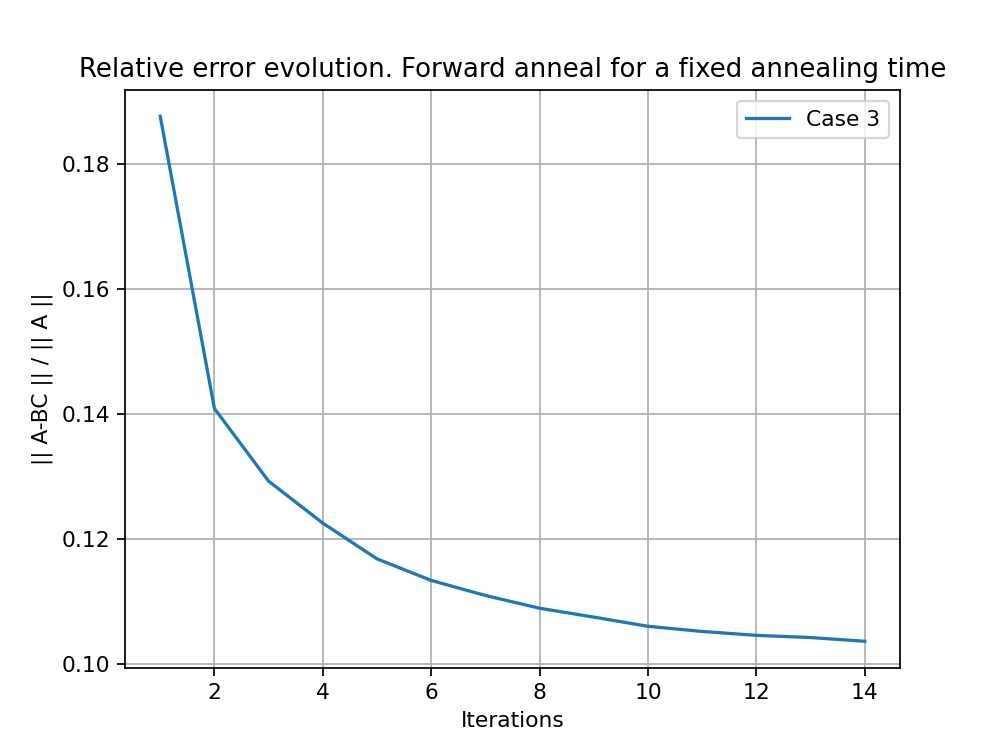

In [17]:
relative_errors= np.loadtxt('relative_errors_tot_it_14_{}.csv'.format(case), delimiter=',')

fig, ax = plt.subplots() 
ax.plot(list(range(1, len(relative_errors)+1)), relative_errors, label='Case {}'.format(case))
ax.grid()
ax.set(xlabel='Iterations', ylabel='|| A-BC || / || A ||', title='Relative error evolution. Forward anneal for a fixed annealing time')
plt.legend()
plt.show()
fig.savefig("Relative error evolution.png")


# Iterative improvement of B

<IPython.core.display.Javascript object>


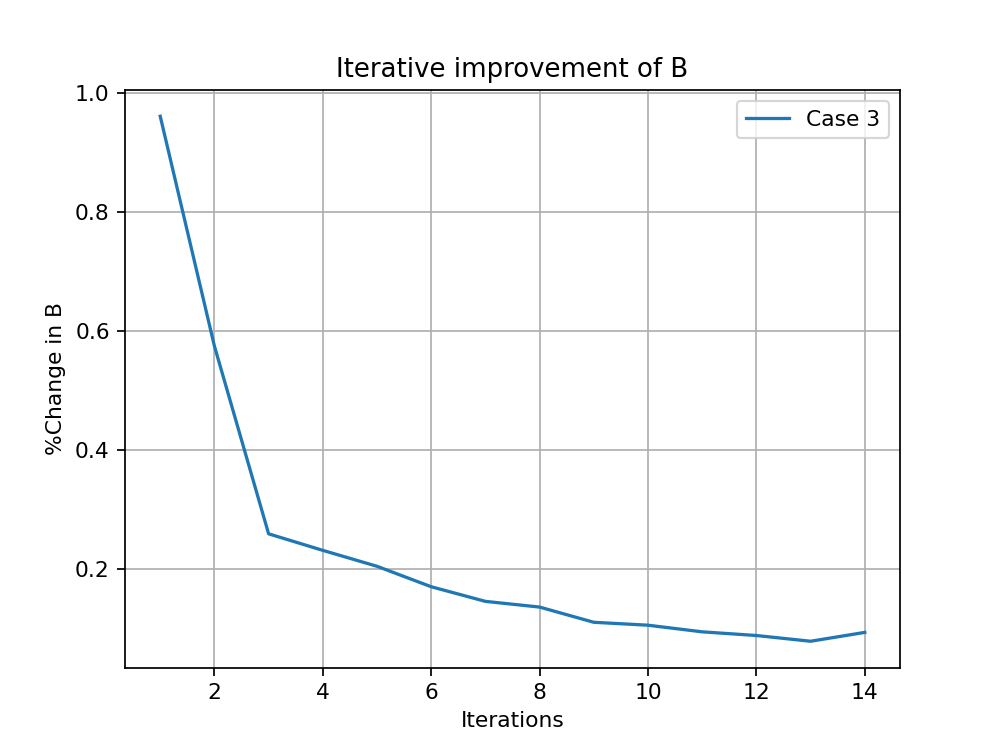

In [18]:
ChangeB= np.loadtxt('%ChangeB_tot_it_14_{}.csv'.format(case), delimiter=',')

fig, ax = plt.subplots() 
ax.plot(list(range(1, len(ChangeB)+1)), ChangeB, label='Case {}'.format(case))
ax.grid()
ax.set(xlabel='Iterations', ylabel='%Change in B', title='Iterative improvement of B')
plt.legend()
plt.show()
fig.savefig("Iterative improvement of B.png")


# Iterative improvement of C

<IPython.core.display.Javascript object>


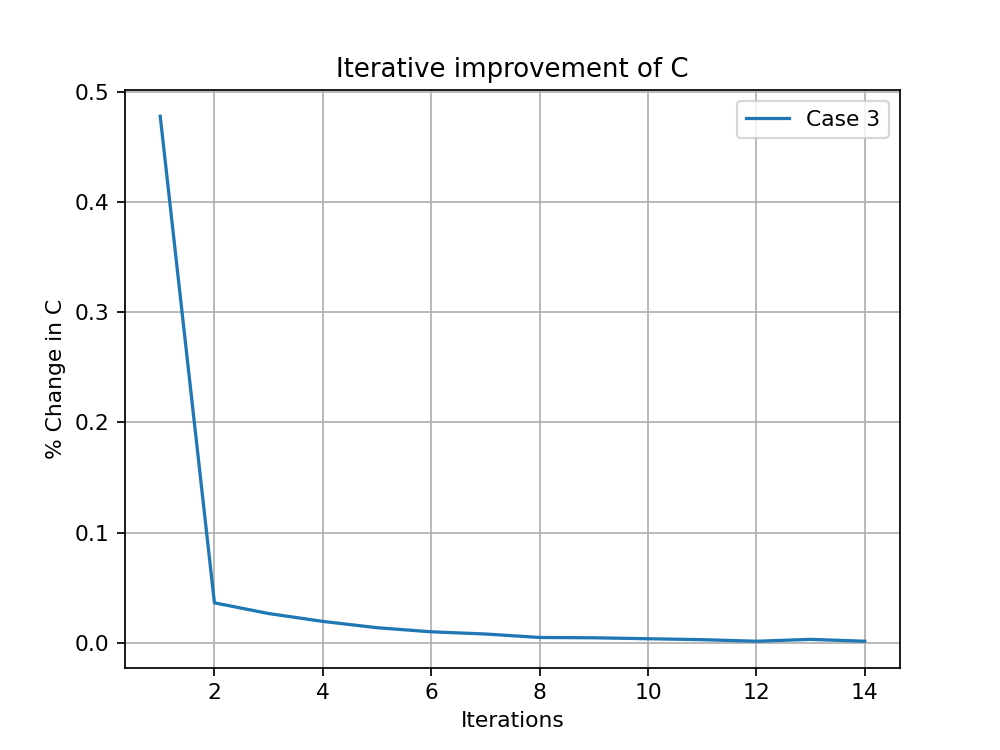

In [20]:
ChangeC=np.loadtxt('%ChangeC_tot_it_14_{}.csv'.format(case), delimiter=',')

fig, ax = plt.subplots() 
ax.plot(list(range(1, len(ChangeC)+1)), ChangeC, label='Case {}'.format(case))
ax.grid()
ax.set(xlabel='Iterations', ylabel='% Change in C', title='Iterative improvement of C')
plt.legend()
plt.show()
fig.savefig("Iterative improvement of C.png")
